In [94]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import cv2

In [95]:
ee.Authenticate()
ee.Initialize()

In [115]:
# Region in the Brazilian Amazon
# Area near the city of Altamira, Pará, Brazil
roi_coordinates = [
    [-55.5, -7.2],
    [-55.5, -7.0],
    [-55.3, -7.0],
    [-55.3, -7.2]
]
roi = ee.Geometry.Polygon([roi_coordinates])

In [116]:
years = range(2018, 2024)
ndvi_images = []

In [114]:
GeoMap = geemap.Map(height=900)
GeoMap.centerObject(roi, 8)

for year in years:
    s_date = f'{year}-01-01'
    e_date = f'{year}-12-31'
    im = (ee.ImageCollection('COPERNICUS/S2')
              .filterDate(s_date, e_date)
              .filterBounds(roi)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 3))
              .select(['B4', 'B3', 'B2'])
              .median())
    GeoMap.addLayer(im, {'min': 0, 'max': 3000}, f'Sentinel-2 {year} RGB')
GeoMap.addLayer(roi, {'color': 'red'}, 'Region of Interest')

In [99]:
GeoMap

Map(center=[-7.100003457086497, -55.399999999999125], controls=(WidgetControl(options=['position', 'transparen…

In [117]:
def compute_ndvi(image):
    nir = image.select('B8')
    red = image.select('B4')
    return nir.subtract(red).divide(nir.add(red)).rename('NDVI')

In [118]:
for year in years:
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    ndvi_year = (ee.ImageCollection('COPERNICUS/S2')
                  .filterDate(start_date, end_date)
                  .filterBounds(roi)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 3))
                  .select(['B8', 'B4'])
                  .median())

    ndvi_images.append(ndvi_year)

In [119]:
ndvi_values = [compute_ndvi(image) for image in ndvi_images]
len(ndvi_values)

6

In [122]:
Map = geemap.Map(height=900)
Map.centerObject(roi, 10)

for idx, ndvi in enumerate(ndvi_values):
    year = years[idx]
    Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'NDVI {year}')

Map.addLayer(roi, {}, 'Region of Interest')
Map.add_colorbar(vis_params={'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, label='NDVI Color Bar')

In [123]:
Map

Map(center=[-7.100003457086497, -55.399999999999125], controls=(WidgetControl(options=['position', 'transparen…

In [126]:
ndvi_features = []
for idx, ndvi in enumerate(ndvi_values):
    ndvi_year_values = ndvi.sample(region=roi, scale=10, numPixels=5000).getInfo()
    ndvi_values_year = np.array([feature['properties']['NDVI'] for feature in ndvi_year_values['features']])
    ndvi_features.append(ndvi_values_year)
    average_ndvi = np.mean(ndvi_values_year)
    print(f"Average NDVI for {years[idx]}: {average_ndvi:.4f}")

Average NDVI for 2018: 0.5870
Average NDVI for 2019: 0.5532
Average NDVI for 2020: 0.5554
Average NDVI for 2021: 0.5617
Average NDVI for 2022: 0.3693
Average NDVI for 2023: 0.3336


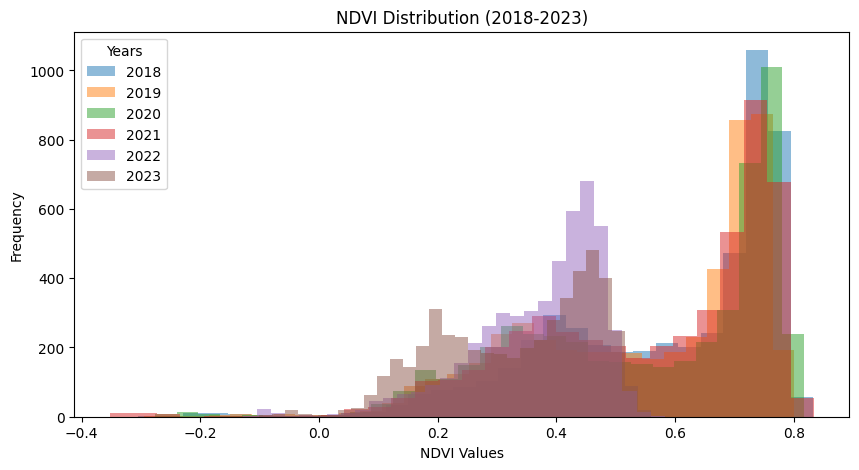

In [108]:
plt.figure(figsize=(10, 5))
for idx, year_values in enumerate(ndvi_features):
    plt.hist(year_values, bins=30, alpha=0.5, label=str(years[idx]))

plt.title('NDVI Distribution (2018-2023)')
plt.xlabel('NDVI Values')
plt.ylabel('Frequency')
plt.legend(title='Years')
plt.show()

In [109]:
average_ndvi = np.mean(ndvi_features, axis=0)

threshold = 0.2
deforestation_mask = np.zeros_like(average_ndvi)

for i in range(len(ndvi_features) - 1):
    ndvi_diff = ndvi_features[i] - ndvi_features[i + 1]
    deforestation_mask += (ndvi_diff > threshold).astype(int)

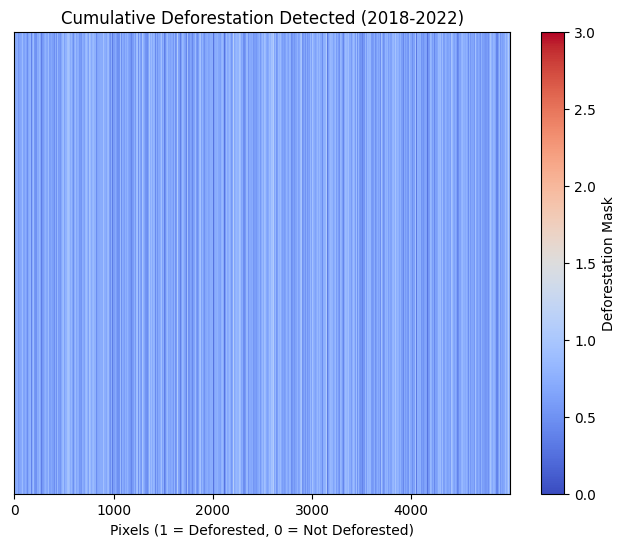

In [110]:
plt.figure(figsize=(8, 6))
plt.title('Cumulative Deforestation Detected (2018-2022)')
plt.imshow(deforestation_mask.reshape(1, -1), cmap='coolwarm', aspect='auto')
plt.colorbar(label='Deforestation Mask')
plt.yticks([])
plt.xlabel('Pixels (1 = Deforested, 0 = Not Deforested)')
plt.show()

In [111]:
pixel_size = 10
deforested_area_km2 = np.sum(deforestation_mask) * (pixel_size ** 2) / 1e6

deforested_area_mi2 = deforested_area_km2 * 0.386102

roi_area_km2 = roi.area().getInfo() * 1e-6
roi_area_mi2 = roi_area_km2 * 0.386102

percent_deforested = (deforested_area_mi2 / roi_area_mi2) * 100

print(f'Total Area of ROI: {roi_area_mi2:.2f} mi²')
print(f'Total Deforested Area from 2018 to 2023: {deforested_area_mi2:.2f} mi²')
print(f'Percentage of Deforested Land: {percent_deforested:.2f}%')

Total Area of ROI: 189.49 mi²
Total Deforested Area from 2018 to 2023: 0.13 mi²
Percentage of Deforested Land: 0.07%
